### Kaggle Fake News classifier

Dataset Link : https://www.kaggle.com/c/fake-news/data#

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN, LSTM, GRU, Bidirectional, Embedding
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing Data 

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Datasets/fake-news/train.csv')

test_df = pd.read_csv('/content/drive/MyDrive/Datasets/fake-news/test.csv')

sample_df = pd.read_csv('/content/drive/MyDrive/Datasets/fake-news/submit.csv')

In [ ]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
train_df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
train_df[train_df['text'].isna()].head()

,id,title,author,text,label
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1


In [ ]:
#Replacing null values with fake news
train_df['text'].fillna('fake news', inplace=True)

test_df['text'].fillna('fake news', inplace=True)

In [ ]:
#Getting the length of the text
train_df['text_len'] = train_df['text'].apply(lambda x : len(x))

In [ ]:
#Filling the null values in the title column
train_df.fillna('fake news', inplace=True)

In [ ]:
test_df.fillna('fake news', inplace=True)

In [ ]:
train_df['title_len'] = train_df['title'].apply(lambda x : len(x))

In [ ]:
train_df['text_len'].max(), train_df['title_len'].max()

(142961, 456)

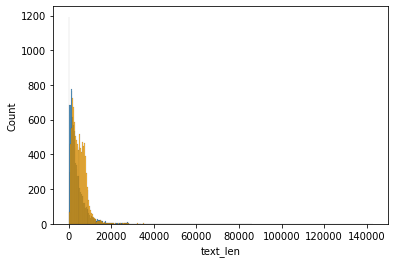

In [ ]:
sns.histplot(train_df.loc[train_df['label']==1, 'text_len'])
sns.histplot(train_df.loc[train_df['label']==0, 'text_len'], color='orange')

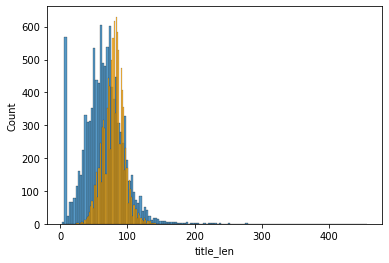

In [ ]:
sns.histplot(train_df.loc[train_df['label']==1, 'title_len'], label='Fake')
sns.histplot(train_df.loc[train_df['label']==0, 'title_len'], color='orange', label='Original')

In [ ]:
pip install contractions


     |████████████████████████████████| 283 kB 11.4 MB/s 
     |████████████████████████████████| 321 kB 35.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85441 sha256=b85b93001fd31a97e62b137cd15bc25b7a559710035e1e613dce8b78c53d8a17
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
import tqdm
#Importing manually created preprocessor script for text processing
from preprocess_engine_kaggle import preprocessor_engine as new_engine

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def corpus_pre_processor(corpus):
    norm_corpus = []
    for doc in tqdm.tqdm(corpus):
        #print(type(doc))
        norm_corpus.append(new_engine(doc, html_strip=False, accent_characters=False, fix_contract=True, remove_stop_words=True , remove_digits=True, lower=False))
        
    return norm_corpus

In [ ]:
train_data_new = corpus_pre_processor(train_df['title'])

100%|██████████| 20800/20800 [03:33<00:00, 97.26it/s]


In [ ]:
test_data_new = corpus_pre_processor(test_df['title'])

100%|██████████| 5200/5200 [00:54<00:00, 94.74it/s]


In [ ]:
train_data_new[:10]

['house dem aide comey s letter jason chaffetz tweet',
 'flynn hillary clinton big woman campus breitbart',
 'truth fire',
 'civilian kill single airstrike identify',
 'iranian woman jail fictional unpublished story woman stone death adultery',
 'jackie mason hollywood love trump bomb north korea lack trans bathrooms exclusive video breitbart',
 'life life luxury elton john s favorite shark pictures stare long transcontinental flight',
 'beno t hamon win french socialist party s presidential nomination new york times',
 'excerpt draft script donald trump s q ampa black church s pastor new york times',
 'channel plan ukraine russia courtesy trump associates new york times']

In [ ]:
train_df['title'].head()[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [ ]:
#Tokenizing the text
tokenzer = tf.keras.preprocessing.text.Tokenizer(oov_token = '<UNK>')
tokenzer.fit_on_texts(train_data_new)

In [ ]:
#Converting into numerical values
train_sequences = tokenzer.texts_to_sequences(train_data_new)
test_sequences = tokenzer.texts_to_sequences(test_data_new)

In [ ]:
print("Vocabulary size ={}".format(len(tokenzer.word_index)))
print("Number of Documents={}".format(tokenzer.document_count))

Vocabulary size =19295
Number of Documents=20800


In [ ]:
pd.Series(train_data_new).apply(lambda x : len(x.split())).max()

46

In [ ]:
MAX_SEQUENCE_LENGTH = 50

#Padding each sentence to maximum length.
train_pad_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding='post')
test_pad_sequneces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding='post')

### Preprocessing 2

In [ ]:
#Trying out another text preprocessing method
import contractions
from bs4 import BeautifulSoup 
import tqdm
import unicodedata
import re
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')
stop_words = nltk.corpus.stopwords.words('english')
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for text in tqdm.tqdm(docs): 
        text = strip_html_tags(text)
        text = re.sub(r'[^a-zA-Z\s]','',text,re.I)
        text = text.lower()
        text = text.strip()
        text = remove_accented_chars(text)
        text = contractions.fix(text)
        tokens = nltk.word_tokenize(text)
        filtered_tokens = [token for token in tokens if token not in stop_words]
        text = " ".join(filtered_tokens)
        text = re.sub(" +", ' ',text)
        text =text.strip()
        norm_docs.append(text)
    return norm_docs

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_data_local = pre_process_corpus(train_df['title'])

100%|██████████| 20800/20800 [00:07<00:00, 2643.97it/s]


In [ ]:
test_data_local = pre_process_corpus(test_df['title'])

100%|██████████| 5200/5200 [00:02<00:00, 2580.20it/s]


In [ ]:
tokenzer = tf.keras.preprocessing.text.Tokenizer(oov_token = '<UNK>')
tokenzer.fit_on_texts(train_data_local)
train_sequences_local = tokenzer.texts_to_sequences(train_data_local)
test_sequences_local = tokenzer.texts_to_sequences(test_data_local)

In [ ]:
pd.Series(train_data_local).apply(lambda x : len(x.split())).max()

56

In [ ]:
MAX_SEQUENCE_LENGTH = 56

train_pad_sequences_local = tf.keras.preprocessing.sequence.pad_sequences(train_sequences_local, maxlen = MAX_SEQUENCE_LENGTH, padding='post')
test_pad_sequneces_local = tf.keras.preprocessing.sequence.pad_sequences(test_sequences_local, maxlen = MAX_SEQUENCE_LENGTH, padding='post')

### Modelling

In [ ]:
 y = train_df['label']

In [ ]:
def deep_model():
  SEED = 42
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  EMBEDDING_DIM = 300 #Dimension for dense embedding for each token
  VOCAB_SIZE = len(tokenzer.word_index)
  model = Sequential()
  model.add((Embedding(input_dim =VOCAB_SIZE+1,output_dim = EMBEDDING_DIM,input_length = MAX_SEQUENCE_LENGTH)))
  model.add(Bidirectional(LSTM(128,return_sequences = True)))
  model.add((Dense(256,activation = 'relu')))
  model.add(Dense(1,activation = 'sigmoid'))

  model.compile(loss = 'binary_crossentropy',optimizer="adam",metrics =['accuracy'])
  return model

In [ ]:
model = deep_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 300)           5788800   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 50, 256)           439296    
_________________________________________________________________
dense_12 (Dense)             (None, 50, 256)           65792     
_________________________________________________________________
dense_13 (Dense)             (None, 50, 1)             257       
Total params: 6,294,145
Trainable params: 6,294,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_pad_sequences, y, epochs=5, validation_split=0.1)

Epoch 1/5
585/585 [==============================] - 62s 101ms/step - loss: 0.2309 - accuracy: 0.9031 - val_loss: 0.1690 - val_accuracy: 0.9359
Epoch 2/5
585/585 [==============================] - 58s 100ms/step - loss: 0.0927 - accuracy: 0.9687 - val_loss: 0.1967 - val_accuracy: 0.9364
Epoch 3/5
585/585 [==============================] - 58s 100ms/step - loss: 0.0493 - accuracy: 0.9846 - val_loss: 0.2336 - val_accuracy: 0.9261
Epoch 4/5
585/585 [==============================] - 58s 99ms/step - loss: 0.0230 - accuracy: 0.9934 - val_loss: 0.3105 - val_accuracy: 0.9246
Epoch 5/5
585/585 [==============================] - 58s 99ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.5273 - val_accuracy: 0.9127


In [ ]:
model.fit(train_pad_sequences, y, epochs=5, validation_split=0.1)

Epoch 1/5
585/585 [==============================] - 127s 109ms/step - loss: 0.2290 - accuracy: 0.9034 - val_loss: 0.1689 - val_accuracy: 0.9392
Epoch 2/5
585/585 [==============================] - 61s 105ms/step - loss: 0.0902 - accuracy: 0.9701 - val_loss: 0.1989 - val_accuracy: 0.9363
Epoch 3/5
585/585 [==============================] - 65s 111ms/step - loss: 0.0507 - accuracy: 0.9844 - val_loss: 0.2628 - val_accuracy: 0.9305
Epoch 4/5
585/585 [==============================] - 65s 111ms/step - loss: 0.0284 - accuracy: 0.9914 - val_loss: 0.3540 - val_accuracy: 0.9190
Epoch 5/5
585/585 [==============================] - 67s 114ms/step - loss: 0.0170 - accuracy: 0.9948 - val_loss: 0.3930 - val_accuracy: 0.9222


In [ ]:
test_pred[:,0].reshape(-1)

array([0, 1, 0, ..., 0, 1, 0], dtype=int32)

In [ ]:
test_pred = model.predict_classes(test_pad_sequneces)
sample_df['label'] = test_pred[:,0].reshape(-1)
sample_df.to_csv('fake_news2.csv', index = None)
files.download('fake_news2.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Local Preprocessor
model = deep_model()
#model.summary()
model.fit(train_pad_sequences_local, y, epochs=5, validation_split=0.1)

Epoch 1/5
585/585 [==============================] - 73s 118ms/step - loss: 0.2428 - accuracy: 0.8965 - val_loss: 0.1657 - val_accuracy: 0.9321
Epoch 2/5
585/585 [==============================] - 68s 117ms/step - loss: 0.0813 - accuracy: 0.9740 - val_loss: 0.2047 - val_accuracy: 0.9271
Epoch 3/5
585/585 [==============================] - 67s 115ms/step - loss: 0.0399 - accuracy: 0.9876 - val_loss: 0.2916 - val_accuracy: 0.9295
Epoch 4/5
585/585 [==============================] - 67s 115ms/step - loss: 0.0188 - accuracy: 0.9949 - val_loss: 0.3891 - val_accuracy: 0.9226
Epoch 5/5
585/585 [==============================] - 68s 116ms/step - loss: 0.0094 - accuracy: 0.9975 - val_loss: 0.4644 - val_accuracy: 0.9184


In [ ]:
test_pred = model.predict_classes(test_pad_sequneces)
sample_df['label'] = test_pred[:,0].reshape(-1)
sample_df.to_csv('fake_news1_local.csv', index = None)
from google.colab import files
files.download('fake_news1_local.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
MAX_SEQUENCE_LENGTH = 50

In [ ]:
def deep_model_stack(layer_name):
  SEED = 42
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  EMBEDDING_DIM = 300 #Dimension for dense embedding for each token
  VOCAB_SIZE = len(tokenzer.word_index)
  model = Sequential()
  model.add((Embedding(input_dim =VOCAB_SIZE+1,output_dim = EMBEDDING_DIM,input_length = MAX_SEQUENCE_LENGTH)))
  model.add((layer_name(128,return_sequences = True)))
  model.add((layer_name(128, return_sequences=False)))
  model.add((Dense(256,activation = 'relu')))
  model.add(Dense(1,activation = 'sigmoid'))

  model.compile(loss = 'binary_crossentropy',optimizer="adam",metrics =['accuracy'])
  return model

In [ ]:
stack_model = deep_model_stack(LSTM)

In [ ]:
stack_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 50, 300)           6902100   
_________________________________________________________________
lstm_16 (LSTM)               (None, 50, 128)           219648    
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 7,286,613
Trainable params: 7,286,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stack_model.fit(train_pad_sequences, y, epochs=5, validation_split=0.1)

Epoch 1/5
585/585 [==============================] - 66s 107ms/step - loss: 0.4514 - accuracy: 0.8012 - val_loss: 0.3283 - val_accuracy: 0.9005
Epoch 2/5
585/585 [==============================] - 62s 106ms/step - loss: 0.2372 - accuracy: 0.9229 - val_loss: 0.2010 - val_accuracy: 0.9264
Epoch 3/5
585/585 [==============================] - 61s 104ms/step - loss: 0.1489 - accuracy: 0.9517 - val_loss: 0.1750 - val_accuracy: 0.9385
Epoch 4/5
585/585 [==============================] - 61s 105ms/step - loss: 0.0909 - accuracy: 0.9744 - val_loss: 0.1992 - val_accuracy: 0.9308
Epoch 5/5
585/585 [==============================] - 62s 106ms/step - loss: 0.0641 - accuracy: 0.9846 - val_loss: 0.2316 - val_accuracy: 0.9380


In [ ]:
def predict(model, num):
  test_pred = model.predict_classes(test_pad_sequneces)
  sample_df['label'] = test_pred[:,0].reshape(-1)
  sample_df.to_csv(f'fake_news{num}.csv', index = None)
  from google.colab import files
  files.download(f'fake_news{num}.csv') 

In [ ]:
predict(stack_model,'stack_LSTM')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
stack_model_gru = deep_model_stack(GRU)

In [ ]:
stack_model_gru.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 50, 300)           6902100   
_________________________________________________________________
gru_8 (GRU)                  (None, 50, 128)           165120    
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_34 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 257       
Total params: 7,199,573
Trainable params: 7,199,573
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stack_model_gru.fit(train_pad_sequences, y, epochs=3, validation_split=0.1)

Epoch 1/3
585/585 [==============================] - 64s 109ms/step - loss: 0.6936 - accuracy: 0.5059 - val_loss: 0.6927 - val_accuracy: 0.5192
Epoch 2/3
585/585 [==============================] - 62s 107ms/step - loss: 0.6934 - accuracy: 0.4968 - val_loss: 0.6927 - val_accuracy: 0.5192
Epoch 3/3
585/585 [==============================] - 62s 107ms/step - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6946 - val_accuracy: 0.4808


In [ ]:
predict(stack_model_gru,' stack_GRU')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def deep_model_stack_bidirect(layer_name):
  SEED = 42
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  EMBEDDING_DIM = 300 #Dimension for dense embedding for each token
  VOCAB_SIZE = len(tokenzer.word_index)
  model = Sequential()
  model.add((Embedding(input_dim =VOCAB_SIZE+1,output_dim = EMBEDDING_DIM,input_length = MAX_SEQUENCE_LENGTH)))
  model.add(Bidirectional(layer_name(128,return_sequences = True)))
  model.add(Bidirectional(layer_name(128, return_sequences=False)))
  model.add((Dense(256,activation = 'relu')))
  model.add(Dense(1,activation = 'sigmoid'))

  model.compile(loss = 'binary_crossentropy',optimizer="adam",metrics =['accuracy'])
  return model

In [ ]:
bidirect_stack_LSTM = deep_model_stack_bidirect(LSTM)
bidirect_stack_LSTM.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 50, 300)           6902100   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 50, 256)           439296    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_30 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 257       
Total params: 7,801,685
Trainable params: 7,801,685
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bidirect_stack_LSTM.fit(train_pad_sequences, y, epochs=5, validation_split=0.1)

Epoch 1/5
585/585 [==============================] - 92s 147ms/step - loss: 0.1942 - accuracy: 0.9177 - val_loss: 0.1553 - val_accuracy: 0.9447
Epoch 2/5
585/585 [==============================] - 83s 141ms/step - loss: 0.0661 - accuracy: 0.9776 - val_loss: 0.1669 - val_accuracy: 0.9380
Epoch 3/5
585/585 [==============================] - 84s 143ms/step - loss: 0.0260 - accuracy: 0.9918 - val_loss: 0.2618 - val_accuracy: 0.9317
Epoch 4/5
585/585 [==============================] - 83s 141ms/step - loss: 0.0098 - accuracy: 0.9973 - val_loss: 0.3350 - val_accuracy: 0.9236
Epoch 5/5
585/585 [==============================] - 82s 140ms/step - loss: 0.0091 - accuracy: 0.9975 - val_loss: 0.3896 - val_accuracy: 0.9149


In [ ]:
predict(bidirect_stack_LSTM,' bidirec_LSTM')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
bidirect_stack_GRU = deep_model_stack_bidirect(GRU)
bidirect_stack_GRU.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 50, 300)           6902100   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 50, 256)           330240    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 256)               296448    
_________________________________________________________________
dense_32 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 257       
Total params: 7,594,837
Trainable params: 7,594,837
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bidirect_stack_GRU.fit(train_pad_sequences, y, epochs=5, validation_split=0.1)

Epoch 1/5
585/585 [==============================] - 90s 144ms/step - loss: 0.1907 - accuracy: 0.9179 - val_loss: 0.1548 - val_accuracy: 0.9433
Epoch 2/5
585/585 [==============================] - 82s 139ms/step - loss: 0.0592 - accuracy: 0.9785 - val_loss: 0.1769 - val_accuracy: 0.9317
Epoch 3/5
585/585 [==============================] - 83s 142ms/step - loss: 0.0212 - accuracy: 0.9927 - val_loss: 0.3401 - val_accuracy: 0.9284
Epoch 4/5
585/585 [==============================] - 83s 142ms/step - loss: 0.0112 - accuracy: 0.9965 - val_loss: 0.2908 - val_accuracy: 0.9351
Epoch 5/5
585/585 [==============================] - 81s 139ms/step - loss: 0.0059 - accuracy: 0.9985 - val_loss: 0.3917 - val_accuracy: 0.9245


In [ ]:
predict(bidirect_stack_GRU,' bidirec_GRU')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>